# Временные ряды

In [1]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/arashnic/time-series-forecasting-with-yahoo-stock-price")

Skipping, found downloaded files in "./time-series-forecasting-with-yahoo-stock-price" (use force=True to force download)


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
stocks = pd.read_csv("time-series-forecasting-with-yahoo-stock-price/yahoo_stock.csv", 
                     header=0, index_col=0,parse_dates=True)

In [4]:
stocks.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [5]:
# оставим только объемы торгов
stocks = stocks[["Volume"]]

In [6]:
stocks.shape

(1825, 1)

In [7]:
stocks.isnull().sum()

Volume    0
dtype: int64

In [8]:
#оставим первые 200 записей для ускорения вычислений
stocks = stocks.iloc[:200]

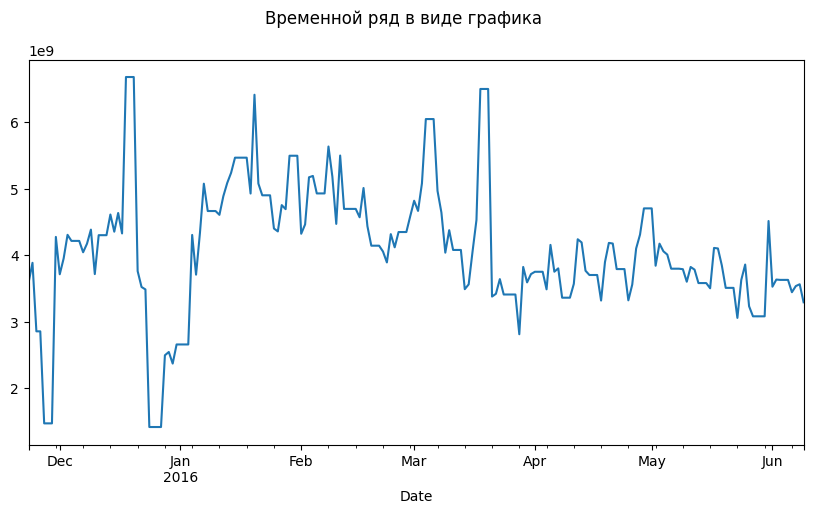

In [9]:
#временной ряд в виде графика
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Временной ряд в виде графика')
stocks.plot(ax=ax, legend=False)
plt.show()


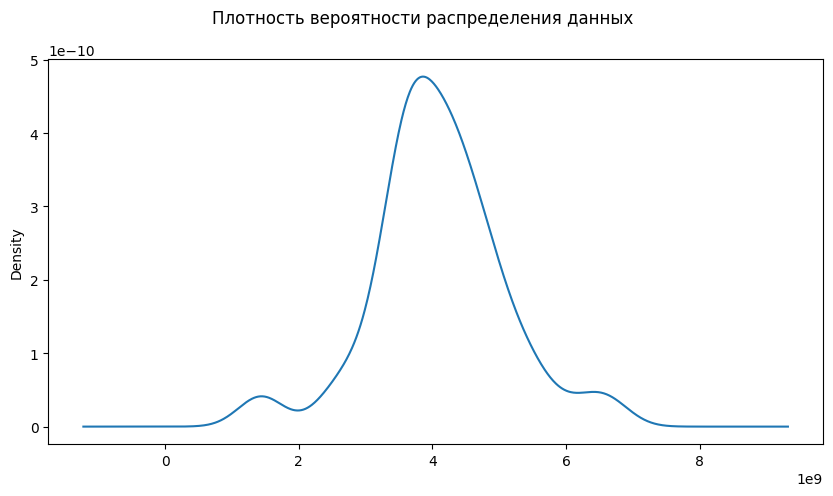

In [10]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Плотность вероятности распределения данных')
stocks.plot(ax=ax, kind='kde', legend=False)
plt.show()

In [11]:
stocks.describe()

,Volume
count,2.000000e+02
mean,4.093263e+09
std,9.780455e+08
min,1.411860e+09
25%,3.576870e+09
50%,4.078620e+09
75%,4.664940e+09
max,6.683070e+09


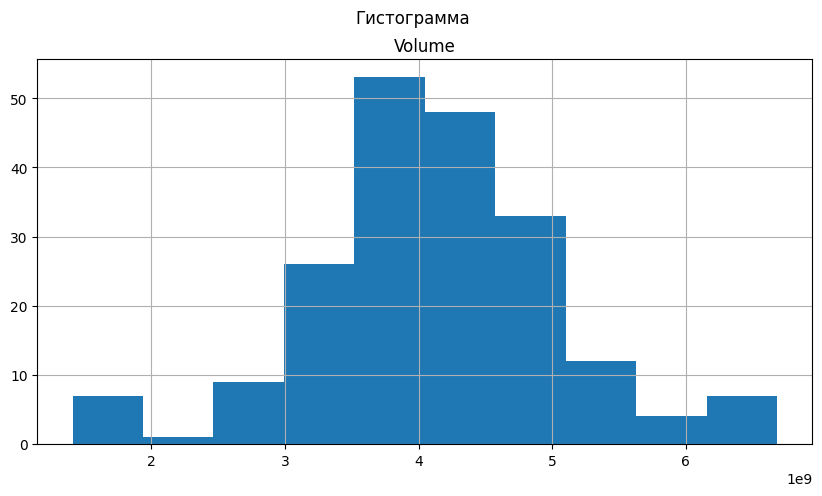

In [12]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Гистограмма')
stocks.hist(ax=ax, legend=False)
plt.show()

Скользящее среднее

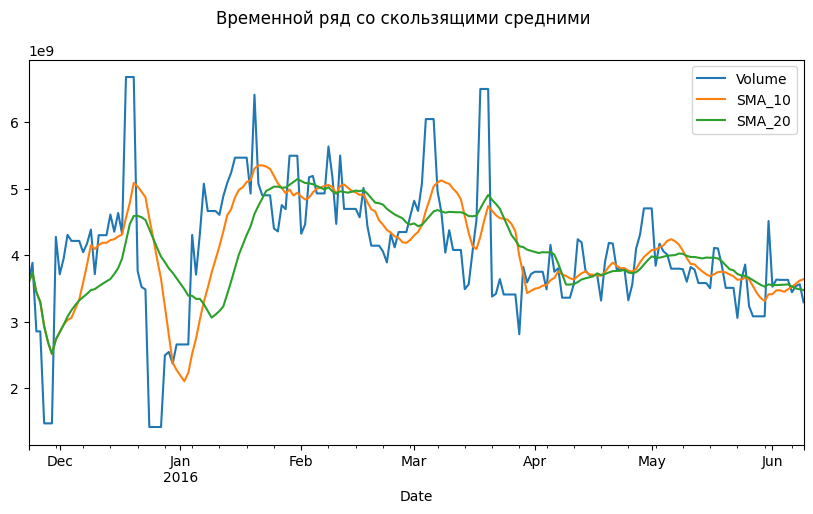

In [13]:
stcp = stocks.copy()
stcp['SMA_10'] = stcp['Volume'].rolling(10, min_periods=1).mean()
stcp['SMA_20'] = stcp['Volume'].rolling(20, min_periods=1).mean()


fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Временной ряд со скользящими средними')
stcp.plot(ax=ax, legend=True)
plt.show()



In [14]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [15]:
# Целочисленная метка шкалы времени 
xnum = list(range(stocks.shape[0]))
# Разделение выборки на обучающую и тестовую
Y = stocks['Volume'].values
train_size = int(len(Y) * 0.7)
xnum_train, xnum_test = xnum[0:train_size], xnum[train_size:]
train, test = Y[0:train_size], Y[train_size:]
history_arima = [x for x in train]
history_es = [x for x in train]


In [16]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [17]:
# подбор гиперпараметров модели
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [ ]:
# вычислим параметры
p_values = [1, 2, 3, 4, 5, 6]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(stocks.values, p_values, d_values, q_values)

ARIMA(9, 5, 5) MSE=223960714328362048.000
ARIMA(10, 5, 4) MSE=189758981796038688.000


По результатам подбора гиперпараметров, наилучшей является модель ARIMA(6,1,2)

In [18]:
# Параметры модели (p,d,q) 
arima_order = (6, 1, 2)
# Формирование предсказаний
predictions_arima = list()
for t in range(len(test)):
    model_arima = ARIMA(history_arima, order=arima_order)
    model_arima_fit = model_arima.fit()
    yhat_arima = model_arima_fit.forecast()[0]
    predictions_arima.append(yhat_arima)
    history_arima.append(test[t])
# Вычисление метрики RMSE
error_arima = mean_squared_error(test, predictions_arima, squared=False)
print(error_arima)

339597549.2241328


In [19]:
# Формирование предсказаний с помощью экспоненциального сглаживания
predictions_es = list()
for t in range(len(test)):
    model_es = ExponentialSmoothing(history_es)
    model_es_fit = model_es.fit()
    yhat_es = model_es_fit.forecast()[0]
    predictions_es.append(yhat_es)
    history_es.append(test[t])
# Вычисление метрики RMSE
error_es = mean_squared_error(test, predictions_es, squared=False)

# Ошибка прогноза
np.mean(Y), error_arima, error_es

/home/anna/notebooks/nb_env/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/anna/notebooks/nb_env/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/anna/notebooks/nb_env/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/anna/notebooks/nb_env/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/anna/notebooks/nb_env/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/anna/notebooks/nb_env/lib/python3.10/site-packages/sta

/home/anna/notebooks/nb_env/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/anna/notebooks/nb_env/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/anna/notebooks/nb_env/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/anna/notebooks/nb_env/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/anna/notebooks/nb_env/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/anna/notebooks/nb_env/lib/python3.10/site-packages/sta

(4093262600.0, 339597549.2241328, 356613059.4587297)

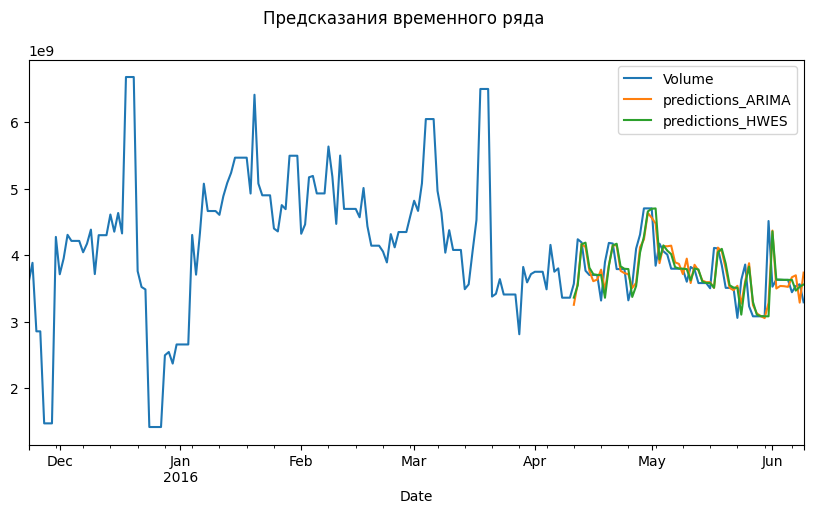

In [21]:
# Записываем предсказания в DataFrame
stocks['predictions_ARIMA'] = (train_size * [np.NAN]) + list(predictions_arima)
stocks['predictions_HWES'] = (train_size * [np.NAN]) + list(predictions_es)
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда')
stocks.plot(ax=ax, legend=True)
plt.show()

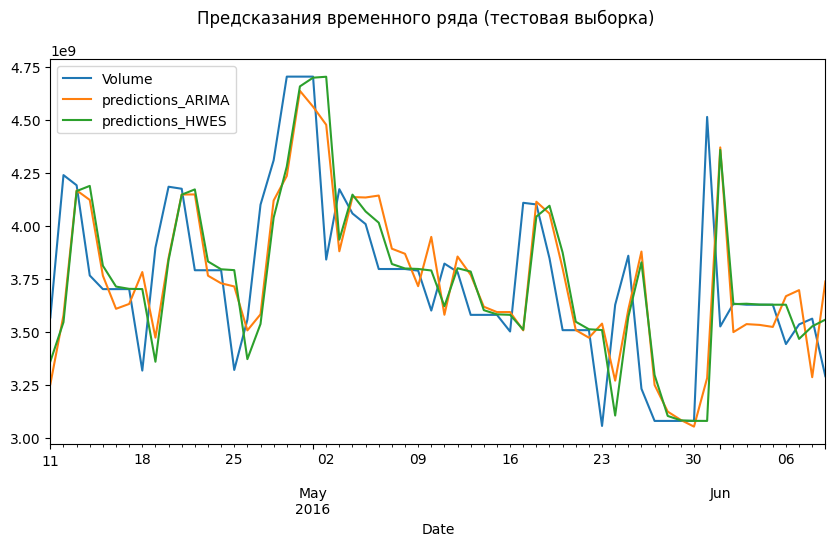

In [22]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда (тестовая выборка)')
stocks[train_size:].plot(ax=ax, legend=True)
plt.show()

Вывод: значение ошибки для модели ARIMA в результате получилось несколько меньше, чем при использовании ExponentialSmoothing. На графике видно, что предсказания, построенные этими методами, в целом повторяют форму реального ряда, но сдвинуты во времени.